# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">



In [411]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs, and it is encouraged for you to do so. Especially during covid and distancing, this can be a way to work with other students and learn alongside one another. As future data scientists, you will often be expected to work with others, and working in pairs can help practice communicating data science concepts.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with a long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them. .
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example: 
```
print(f'The R^2 is {R:.4f}')
```

<hr style="height:2pt">

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [413]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [414]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [415]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

## Contents
- [Question 1 [20pts]: A Single Model](#Question-1-[20pts]:-A-Single-Model) 
- [Question 2 [25pts]: Bagging](#Question-2-[25pts]:-Bagging) 
- [Question 3 [20pts]: Random Forests](#Question-3-[20pts]:-Random-Forests) 
- [Question 4 [20pts]: Boosting](#Question-4-[20pts]:-Boosting) 
- [Question 5 [15pts]: Understanding](#Question-5-[15pts]:-Understanding) 

### <div class='exercise'>Question 1 [20pts]: A Single Model</div>
[▲ Return to contents](#Contents)
<div class='exercise'>
    
We start by fitting a basic model, which will serve as our baseline model -- a model that we can use as a starting point and can reasonably compare to other models. We will pick a decision tree as our baseline model, and we will later include bagging, random forests, and boosting. We want a fair comparison, so it is important to keep important aspects of the experiments consistent (e.g., the training/dev/testing data). We will tune the decision tree using cross-validation (of course). We will tune the maximum tree depth; we refer to this hyper-parameter as "depth" for simplicity.

Since we will only use tree-based methods in this homework, we do not need to standardize or normalize the predictors/independent variables. 

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, using tree depths from 1 to 20 (inclusive):
- fit a decision tree to the **training** set
- evaluate on the **training** set (i.e., `.score()`), while storing the scores in a variable named `train_scores`
- using cross-validation, evaluate on the **training** set while storing the mean and +/- 2 standard deviations in variables named `cvmeans` and `cvstds`, respectively.

Now that we have these informative scores, let us plot them. Specifically, for each tree-depth (x-axis) plot on the y-axis: (a) the initial, non-cross-validation training scores; and (b) a shaded region that illustrates cross-validations' estimated mean +/- 2 standard deviations. (c) set the limits on the y-axis to focus on the cross-validation performance.

*Hint:* use `plt.fill_between()` to shade the region.
    
**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracy on the **test** set. Store the training and testing accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

**1.3** What is the name of the mechanism by which limiting the tree's depth avoids over-fitting? What is one downside of limiting the tree depth? 
    
</div>

## Answers

<div class='exercise-r'>  
 
**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, using tree depths from 1 to 20 (inclusive):
 - fit a decision tree to the **training** set
 - evaluate on the **training** set (i.e., `.score()`), while storing the scores in a variable named `train_scores`
 - using cross-validation, evaluate on the **training** set while storing the mean and +/- 2 standard deviations in variables named `cvmeans` and `cvstds`, respectively.
 
 Now that we have these informative scores, let us plot them. Specifically, for each tree-depth (x-axis) plot on the y-axis: (a) the initial, non-cross-validation training scores; and (b) a shaded region that illustrates cross-validations' estimated mean +/- 2 standard deviations. (c) set the limits on the y-axis to focus on the cross-validation performance.
 
 *Hint:* use `plt.fill_between()` to shade the region.
 
 </div>

In [416]:
depths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []

def calc_meanstd(X_train, y_train, depths):
    
    for i in depths:
        dtree = DecisionTreeClassifier(max_depth=i)
        scores = cross_val_score(estimator=dtree, X=X_train, y=y_train, cv=5)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        train_scores.append(dtree.fit(X_train,y_train).score(X_train,y_train))
            
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores= calc_meanstd(X_train, y_train, depths)

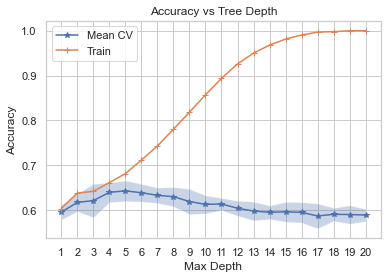

In [417]:
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, (cvmeans - (2*cvstds)), cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.title("Accuracy vs Tree Depth")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);

<div class='exercise-r'>  
 
**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracy on the **test** set. Store the training and testing accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.
 
 </div>

In [418]:
depth = 1
dtree = DecisionTreeClassifier(max_depth=depth)
dtree.fit(X_train,y_train)
single_tree_train_score = dtree.score(X_train,y_train)
single_tree_test_score = dtree.score(X_test,y_test)

training_acc = []
test_acc = []

training_acc.append(single_tree_train_score)
test_acc.append(single_tree_test_score)

In [419]:
#chosen max depth = 5 -> greatest score for the mean scores of the cv sets.
depth = 5
dtree = DecisionTreeClassifier(max_depth=depth)
dtree.fit(X_train,y_train)
best_cv_tree_train_score = dtree.score(X_train,y_train)
best_cv_tree_test_score = dtree.score(X_test,y_test)


In [420]:
best_cv_tree_train_score , best_cv_tree_test_score

(0.6812, 0.6482)

In [421]:
display(dtree)

DecisionTreeClassifier(max_depth=5)

In [422]:
print("train accuracy best cv: ", best_cv_tree_train_score )
print("test accuracy best cv: ",  best_cv_tree_test_score)

training_acc.append(best_cv_tree_train_score)
test_acc.append(best_cv_tree_test_score)

train accuracy best cv:  0.6812
test accuracy best cv:  0.6482


<div class='exercise-r'>  
 
**1.3** What is the name of the mechanism by which limiting the tree's depth avoids over-fitting? What is one downside of limiting the tree depth?
 
 </div>

The stopping condition is the mechanism by which we limit the trees depth and avoid overfitting. The stopping condition tells us how many splits each portion of of our tree is allowed to have or number of branches. By limiting the number of branches, we create a more general model, but reduce the complexity of our model. For certain models we may want more or less branches depending on the correlations and size of the data set. 

Another method for doing this could be pruning. This would consist of growing the tree out long and then cutting or pruning it back to a subtree. 

### <div class='exercise'>Question 2 [25pts]: Bagging</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
Bagging is the technique of building the same model on multiple bootstrap samples from the data and combining each model's prediction to get an overall classification. In this question, we build an example by hand and study how the number of bootstrapped datasets impacts the resulting classification accuracy.



**2.1** Using decision trees and the previous question's data, choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 55 bootstrapped replications of the original training data and fit a decision tree to each (using the tree depth you just chose in 2.1). Record each of the 55 trees' predictions. In particular, produce a dataset like those shown below, where each row is either a training and testing observation (depending on the partition of data at hand), and each column is one of the 55 trees. Each entry within a (row, col) is the corresponding tree's prediction for that observation.

Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.

**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging test accuracy to a variable named `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions()` function (given below) to get the model's accuracy score when using only $N$ of the bootstrapped models, where $N \in [1, 2, 3, ..., 55]$. Make a plot that illustrates the accuracy on the training set and testing set, as a function of the number of bootstraps (vary $N$ from 1 to 55). 
**Use the depth from 2.1** 

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample()` from `sklearn` to easily bootstrap the $x$ and $y$ data.
- use `np.mean()` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?
    
</div>

## Answers

<div class='exercise-r'>  
 
**2.1** Using decision trees and the previous question's data, choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below.)
 
 </div>

In [423]:
tree_depth = 18


I know that this value will overfit from the previous graph that I developed in problem 1.2. The accuracy on the training data is 1, which is a high indicator that the data has been overfit as each data point is tailored to a to the fit line. You can also see that the mean cv accuracy for the depth of 18 has gone down significantly from the previously selected ideal depth of 5.

<div class='exercise-r'>  
 
**2.2** Create 55 bootstrapped replications of the original training data and fit a decision tree to each (using the tree depth you just chose in 2.1). Record each of the 55 trees' predictions. In particular, produce a dataset like those shown below, where each row is either a training and testing observation (depending on the partition of data at hand), and each column is one of the 55 trees. Each entry within a (row, col) is the corresponding tree's prediction for that observation.
 
 Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.
 
 </div>

**Structure of `bagging_train_df` and `bagging_test_df`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 55's prediction|  
| --- | --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 55's prediction|
| --- | --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


In [424]:
    """A function that takes as 
        
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """

'A function that takes as \n    \nInputs:\n  n_tres\n  tree_depth \n  a random_seed (default =0)\n\nReturns:\n  bagging_train dataframe (as described above)\n  bagging_test dataframe (as described above)\n  bagging_models every trained model for each bootstrap (you will need this in Q3.2)\n'

In [425]:
bagging_models = []
num_bootstraps = 55
indexes_train = ["training row "+str(i+1) for i in range(len(X_train))]
col = ["bootstrap model "+str(i+1) + "'s prediction" for i in range(num_bootstraps)]
bagging_train = pd.DataFrame(columns = col, index = indexes_train)
bagging_train
col[0]

"bootstrap model 1's prediction"

In [426]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    #create df list and col names'
    num_bootstraps = 55
    indexes_train = ["training row "+str(i+1) for i in range(len(X_train))]
    indexes_test = ["testing row "+str(i+1) for i in range(len(X_test))]
    predictions = []
    predictions_train =[]
    #create dataframes
    bagging_train = pd.DataFrame(columns = col, index = indexes_train)
    bagging_test = pd.DataFrame(columns = col, index = indexes_test)
    bagging_models = []
    #bagging_models = pd.DataFrame(columns = cols)
    dt_model = DecisionTreeClassifier(max_depth = tree_depth, random_state = 44)

    for i in range(num_bootstraps):
        #bootstrap
        resample_indexes = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0])
        X_boot = X_train[resample_indexes]
        y_boot = y_train[resample_indexes]
        
        #create, fit, and predict on model
        dt_model.fit(X_boot,y_boot)
        pred_train = dt_model.predict(X_train)
        pred_test = dt_model.predict(X_test)
        
        #append to dfs from the y_pred results
        #col = ["bootstrap model "+str(i+1) +"'s prediction"]
      
        bagging_train[col[i]] = pred_train
        bagging_test[col[i]] = pred_test
        bagging_models.append(dt_model.tree_.feature[0])
        predictions.append(pred_test)
        predictions_train.append(pred_train)

    bagging_accuracy_train = (np.mean(np.array(predictions_train), axis = 0) > 0.5)*np.ones(len(predictions_train[0]))
    bagging_accuracy_test = (np.mean(np.array(predictions), axis = 0) > 0.5)*np.ones(len(predictions[0]))

    return bagging_train, bagging_test, bagging_models, bagging_accuracy_test, bagging_accuracy_train, predictions, dt_model

In [427]:
# your code here

bagging_train, bagging_test, bagging_models, bagging_accuracy_test, bagging_accuracy_train,  predictions, dt_model = bagger(55,tree_depth)


In [428]:
bagging_train

,bootstrap model 1's prediction,bootstrap model 2's prediction,bootstrap model 3's prediction,bootstrap model 4's prediction,bootstrap model 5's prediction,bootstrap model 6's prediction,bootstrap model 7's prediction,bootstrap model 8's prediction,bootstrap model 9's prediction,bootstrap model 10's prediction,bootstrap model 11's prediction,bootstrap model 12's prediction,bootstrap model 13's prediction,bootstrap model 14's prediction,bootstrap model 15's prediction,bootstrap model 16's prediction,bootstrap model 17's prediction,bootstrap model 18's prediction,bootstrap model 19's prediction,bootstrap model 20's prediction,bootstrap model 21's prediction,bootstrap model 22's prediction,bootstrap model 23's prediction,bootstrap model 24's prediction,bootstrap model 25's prediction,bootstrap model 26's prediction,bootstrap model 27's prediction,bootstrap model 28's prediction,bootstrap model 29's prediction,bootstrap model 30's prediction,bootstrap model 31's prediction,bootstrap model 32's prediction,bootstrap model 33's prediction,bootstrap model 34's prediction,bootstrap model 35's prediction,bootstrap model 36's prediction,bootstrap model 37's prediction,bootstrap model 38's prediction,bootstrap model 39's prediction,bootstrap model 40's prediction,bootstrap model 41's prediction,bootstrap model 42's prediction,bootstrap model 43's prediction,bootstrap model 44's prediction,bootstrap model 45's prediction,bootstrap model 46's prediction,bootstrap model 47's prediction,bootstrap model 48's prediction,bootstrap model 49's prediction,bootstrap model 50's prediction,bootstrap model 51's prediction,bootstrap model 52's prediction,bootstrap model 53's prediction,bootstrap model 54's prediction,bootstrap model 55's prediction
training row 1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
training row 2,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
training row 3,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
training row 4,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
training row 5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training row 4996,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
training row 4997,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
training row 4998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
training row 4999,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1

<div class='exercise-r'>  
 
**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging test accuracy to a variable named `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in Question 1.
 
 </div>

In [429]:
test_bagging_accuracy = accuracy_score(bagging_accuracy_test, y_test)
print(f'Accuracy with Bootstrapped Aggregation is  {test_bagging_accuracy*100}%')
train_bagging_accuracy = accuracy_score(bagging_accuracy_train, y_train)
print(f'Accuracy with Bootstrapped Aggregation is  {train_bagging_accuracy*100}%')

Accuracy with Bootstrapped Aggregation is  69.02000000000001%
Accuracy with Bootstrapped Aggregation is  99.83999999999999%


The accuracy I received was 4% greater than what I got in my basic model earlier. 68 is greater than 64 (what do you want in terms of an assertion, this seems like an obvious comparison)

<div class='exercise-r'>  
 
**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions()` function (given below) to get the model's accuracy score when using only $N$ of the bootstrapped models, where $N \in [1, 2, 3, ..., 55]$. Make a plot that illustrates the accuracy on the training set and testing set, as a function of the number of bootstraps (vary $N$ from 1 to 55).
 **Use the depth from 2.1**
 
 On your plot, also include horizontal lines for two baselines:
 - the test accuracy of the best model from question 1
 - the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.
 
 </div>

In [430]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

In [431]:
accuracy_test = running_predictions(bagging_test, y_test)
accuracy_train = running_predictions(bagging_train, y_train)
training_acc.append(accuracy_train[54])
test_acc.append(accuracy_test[54])

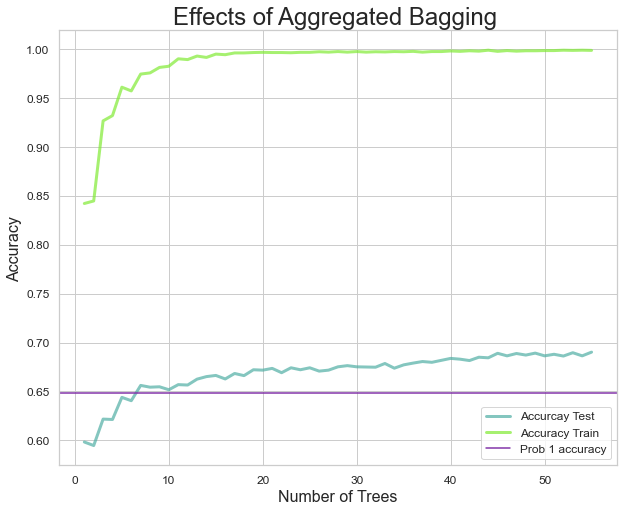

In [432]:
n = np.linspace(1,55,55).astype(int)
acc = []
#for n_i in n:
#    acc.append(np.mean(prediction_by_bagging(X_train, y_train, X_test, n_i)==y_test))
plt.figure(figsize=(10,8))
plt.plot(n,accuracy_test,alpha=0.7,linewidth=3,color='#50AEA4', label='Accurcay Test')
plt.plot(n,accuracy_train,alpha=0.7,linewidth=3,color='#80eb34', label='Accuracy Train')
plt.axhline(y=best_cv_tree_test_score, color='#8132a8', label ='Prob 1 accuracy')

plt.title('Effects of Aggregated Bagging ',fontsize=24)
plt.xlabel('Number of Trees',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

<div class='exercise-r'>  
 
**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.
 
 </div>

The tree_depth of 1 performed pretty well when compared to the lower levels of bagging. We can also see diminishing returns from larger numbers of trees in our aggregated bagging method. We surpass the accuracy of our first single tree model around 10 bagging iterations and top out on accuracy around 30 trees. 

<div class='exercise-r'>  
 
**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.
 
 </div>

It seems like there is a sweet spot to hit for both of these and you could ultimately optimize tree depth first then bagging as we did in this exercise to increase your overall model accuracy. It appears harder to overfit with bagging than with tree depth. We see our graph taper to a horizontal line for our test accuracy in 2.4 rather than dip back down where as we see a dip back down with tree depth. 

<div class='exercise-r'>  
 
**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?
 
 **Hints**
 - Use `resample()` from `sklearn` to easily bootstrap the $x$ and $y$ data.
 - use `np.mean()` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?
 
 </div>

From the graph above, it is hard to see evidence of much of an exagerated overfitting in a way that then effects the test outcome. It is clear that it does end up fitting to the train data to a nearly 100% accuracy which would be an overfit, but this doesn't effect the overall accuracy on the test set much since we are just further aligning the set number of boundaries, rather than extending and creating new boundaries. In this sense I don't see how we could truely overfit to the point where we impact the test data significantly. In terms of underfitting, when we aren't training enough samples, we are effectively training on a set of smaller and less representative data sets, thus we need to increase the number of bagging iterations.

### <div class='exercise'>Question 3 [20pts]: Random Forests</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
Random Forests are closely related to the bagging model we built by hand in question 2. In this question, we compare our by-hand results with the results of using `RandomForestClassifier` directly.


**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2. Set the number of features to use when looking for the best split to be  `sqrt(total_number of features)`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.

**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them on the screen.

Explain:
* What about the process of training the Random Forest causes this difference?
* What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a Pandas table of the training and test accuracy for the following models and name it `results_df`:

- Single tree with the best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 55 such trees (from Question 2)
- A Random Forest of 55 such trees (from Question 3.1)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

</div>

## Answers

<div class='exercise-r'>  
 
**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2. Set the number of features to use when looking for the best split to be  `sqrt(total_number of features)`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.
 
 </div>

In [433]:
# your code here
#random forrest default applies the sqrt features 
model = RandomForestClassifier(max_depth=tree_depth)
model.fit(X_train, y_train)
#Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Perfromance Evaluation
acc_random_forest_training = accuracy_score(y_train, y_pred_train)*100
acc_random_forest_testing = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(acc_random_forest_training))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(acc_random_forest_testing))

training_acc.append(acc_random_forest_training)
test_acc.append(acc_random_forest_testing)


Random Forest: Accuracy, Training Set : 99.96%
Random Forest: Accuracy, Testing Set :  69.46%


In [434]:
random_forest_test_score = acc_random_forest_testing

<div class='exercise-r'>  
 
**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them on the screen.
 
 Explain:
 * What about the process of training the Random Forest causes this difference?
 * What implication does this observation have on the accuracy of bagging vs Random Forest?
 
 **Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
 
 </div>

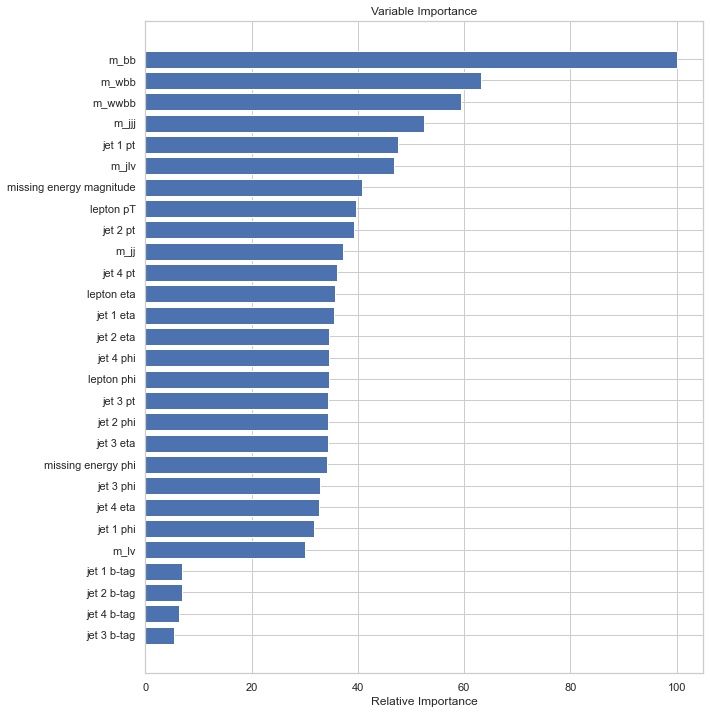

In [435]:
#incomplete
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
#top_predictors_bagging = pd.Series()
#top_predictors_rf = pd.Series()

In [436]:
top_predictors_rf = pd.Series()
top_predictors_rf = pos


/Users/stevenmorse/opt/anaconda3/envs/cs109a_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


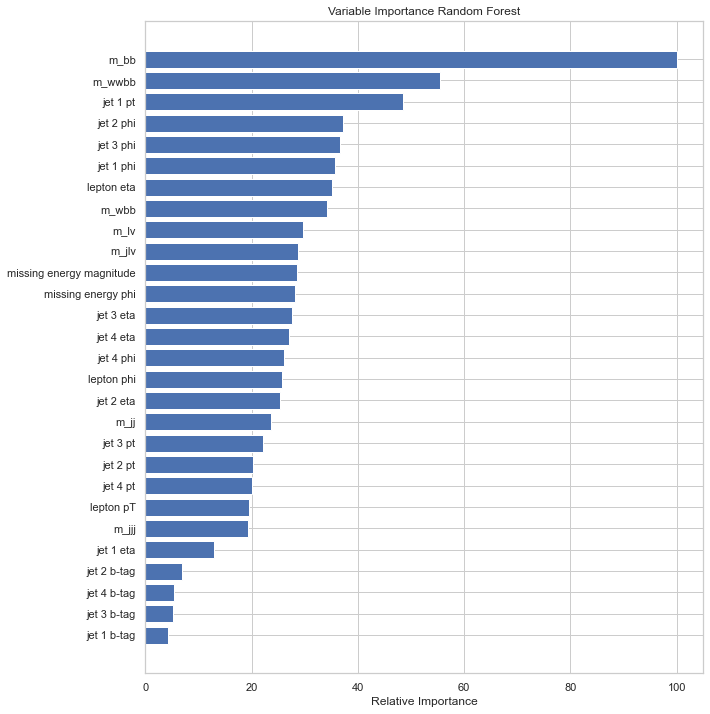

/Users/stevenmorse/opt/anaconda3/envs/cs109a_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [437]:
#incomplete
feature_importance = dt_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance Random Forest')
plt.show()
top_predictors_bagging = pd.Series()
top_predictors_bagging = pos

What about the process of training the Random Forest causes this difference?
The standard decision tree is more chunked in the graphing or flatly spread vs the random forest which has a more flowing slope. The decision tree seems to favor certain chunks of variables over others from the data and put much more weight in them. The reason for this is related to the way the data is selected for the tree. In Random forest a random selection of characteristics are pulled where as in the regular decision tree model we just use the entire set. This seems to weight certain factors in the decision tree much higher except the absolute tail where as the random forrest seems to go a better job of focusing on the weighting less generally and getting a more accuracte reading on each piece due to the aggregation.

What implication does this observation have on the accuracy of bagging vs Random Forest?
Since random forest is better able to generalize over a large set of factors, we are able to get a more accurate responese than the decision tree. Decision trees remain more easy to interpret however than the random forest which needs to average the other trees. 



<div class='exercise-r'>  
 
**3.3**: Make a Pandas table of the training and test accuracy for the following models and name it `results_df`:
 
 - Single tree with the best depth chosen by cross-validation (from Question 1)
 - A single overfit tree trained on all data (from Question 2, using the depth you chose there)
 - Bagging 55 such trees (from Question 2)
 - A Random Forest of 55 such trees (from Question 3.1)
 
 (see below for the expected structure)
 
 (This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)
 
 What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.
 
 </div>

Fill in the following table.


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 55 depth-X trees | | |
| Random Forest of 55 depth-X trees | | |

In [438]:

display(training_acc)
display(test_acc)

[0.6036, 0.6812, 0.9984, 99.96000000000001]

[0.6132, 0.6482, 0.6902, 69.46]

In [439]:

ind = ['single tree with best depth chosen by CV', 'single depth-X tree', 'bagging 55 depth-X trees', 'Random Forest of 55 depth-X trees']
results_df = pd.DataFrame()
results_df['classifier']  = ind
results_df['training accuracy'] = training_acc
results_df['test accuracy'] = test_acc

display(results_df)

,classifier,training accuracy,test accuracy
0,single tree with best depth chosen by CV,0.6036,0.6132
1,single depth-X tree,0.6812,0.6482
2,bagging 55 depth-X trees,0.9984,0.6902
3,Random Forest of 55 depth-X trees,99.9600,69.4600


What is the relative performance of each model on the training set? 
The performance of the single tree is low for the train and test, but the two results are very similar. The same can be said with the single depth tree where the results are relatively similar. This is due to a lack of overfitting on each of these models as they are relatively simple and not very deep. However when we chose the depth of 18 and performed bagging we see much higher signs of overfitting with how close the training accuracy is to a 100% fit. While the last two models in this table did overfit, this overfitting sign of the perfect train accuracy is due more in part to the bagging process which doesn't have the same corresponding effect of overfitting passed on to the test accuracy that you would expect if we were instead just progressively increasing the depth of the trees.

### <div class='exercise'>Question 4 [20pts]: Boosting</div>
[▲ Return to contents](#Contents)

<div class='exercise'>
In this question, we explore a different kind of ensemble method, boosting. Each new model is trained on a dataset weighted towards observations that the current model predicts incorrectly. 

We will focus on the AdaBoost flavor of boosting and examine the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?
    
*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws:
1. Imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code.
2. Imagine that you're the TF writing the solutions; make an excellent example implementation.
3. Use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now, let us use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and the number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?
</div>

## Answers

<div class='exercise-r'>  
 
**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data.
 Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?
 
 *Hints*:
 - If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
 - [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.
 
 </div>

In [440]:
#decision tree classifier
tree1 = DecisionTreeClassifier(max_depth = 3)
tree1.fit(X_train, y_train)
tree1_acc_train = tree1.score(X_train, y_train)
tree1_acc_test = tree1.score(X_test, y_test)
print(f'tree1 accuracy train = {tree1_acc_train*100}%')
print(f'tree1 accuracy test = {tree1_acc_test*100}%')


tree1 accuracy train = 64.18%
tree1 accuracy test = 64.42%


In [ ]:
X_train_trans = X_train.transpose()
X_train_trans = X_train.transpose()

proba_1 = tree1.predict_proba(X_train)[:,1]
proba_0 = tree1.predict_proba(X_train)[:,0]
#plot values of proba_1 and proba_0 with linspace 55 to get the requested chart - this didn't work 

tree1.predict_proba(X_train)

a = np.linspace(1,5000, 5000)

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Predictors Observations Probabilities')

ax1.set_title('probaboility correct')
ax1.set_xlabel('probability point')
ax1.set_ylabel('occurence rate')

sns.kdeplot(ax = ax1, data=proba_0)
fig.subplots_adjust(hspace=2)

ax2.set_title('probability incorrect')
ax2.set_xlabel('probability point')
ax2.set_ylabel('occurence rate')

sns.kdeplot(ax = ax2, data=proba_1)
proba_1.shape

#I'm not really sure what I'm doing wrong here
ax3.plot(a,proba_1)


Ran out of time a bit here. Maybe one of the most stressful weeks ever at Harvard with the election and also Leave of Absence decisions being mismanaged by my college. Apologies for this section being unfinished. 

<div class='exercise-r'>  
 
**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws:
 1. Imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code.
 2. Imagine that you're the TF writing the solutions; make an excellent example implementation.
 3. Use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.
 
 </div>

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [443]:
def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


1. note to student: Please use more comments throughout your process explaining what you are doing. This makes things easier to interpret. Also consider simplifying your for loops as they got quite clunky. The accuracy being so low show be an indicator to you that something is wrong with your method and you need to re-evaluate. You do now need to manually check on each section with y_train when you use predict_proba

In [447]:
# your code here
def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    q = 0
    tree1_accuracy = tree1.score(X_train, y_train)
    print("tree1 accuracy:", tree1_accuracy)
    tree2 = tree.fit(X_train, y_train)
# Train
    for idx in X_train:
        t1p = tree1.predict_proba([idx])[0][1]
        t2p = tree2.predict_proba([idx])[0][1]
        m = (t1p + t2p) / 2
    print("Boosted accuracy train:", m)

# Test
    for idx in X_test:
        t1p = tree1.predict_proba([idx])[0][1]
        t2p = tree2.predict_proba([idx])[0][1]
        m = (t1p + t2p) / 2
       
    print("Boosted accuracy test:", m)   
    
boostmeup(X_train, y_train)



tree1 accuracy: 0.6418
Boosted accuracy train: 0.6867145421903053
Boosted accuracy test: 0.4742268041237113


<div class='exercise-r'>  
 
**4.3** Now, let us use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.
 
 *Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.
 
 </div>

In [445]:
AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=3), n_estimators=800, learning_rate=0.05)
AdaBoost.fit(X_train, y_train)
Ada_acc_train = AdaBoost.score(X_train,y_train)
Ada_acc_test = AdaBoost.score(X_test,y_test)
print(f'AdaBoost accuracy train = {Ada_acc_train*100}%')
print(f'AdaBoost accuracy test = {Ada_acc_test*100}%')

AdaBoost accuracy train = 90.25999999999999%
AdaBoost accuracy test = 66.7%


In [448]:
Ada_acc_train = []
Ada_acc_test = []
estimators = 1 
for i in range(10):
    estimators = (i+1)*80
    AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=3), n_estimators=estimators, learning_rate=0.05)
    AdaBoost.fit(X_train, y_train)
    Ada_acc_train.append(AdaBoost.score(X_train,y_train))
    Ada_acc_test.append(AdaBoost.score(X_test,y_test))

print("done")

done


Note that the above takes forever to run. 

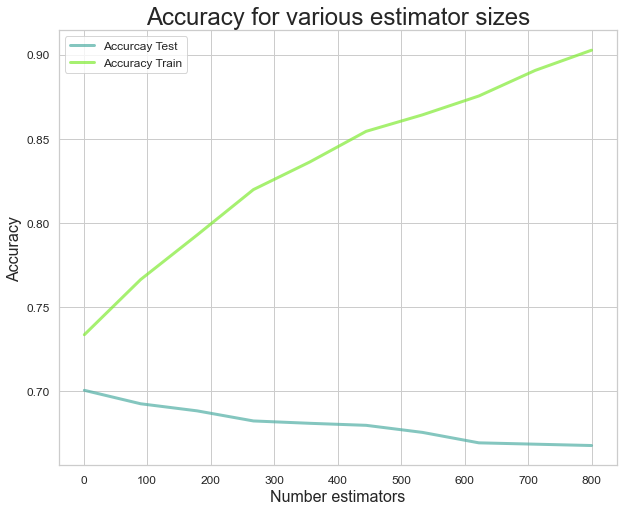

In [449]:
n = np.linspace(1,800,10)
plt.figure(figsize=(10,8))
plt.plot(n,Ada_acc_test,alpha=0.7,linewidth=3,color='#50AEA4', label='Accurcay Test')
plt.plot(n,Ada_acc_train,alpha=0.7,linewidth=3,color='#80eb34', label='Accuracy Train')

plt.title('Accuracy for various estimator sizes',fontsize=24)
plt.xlabel('Number estimators',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

<div class='exercise-r'>  
 
**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?
 
 (It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)
 
 </div>

In [450]:
# your code here
Ada_acc_train1 = []
Ada_acc_test1 = []
estimators = 1 
for i in range(10):
    estimators = (i+1)*80
    AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1), n_estimators=estimators, learning_rate=0.05)
    AdaBoost.fit(X_train, y_train)
    Ada_acc_train1.append(AdaBoost.score(X_train,y_train))
    Ada_acc_test1.append(AdaBoost.score(X_test,y_test))

print("done")

Ada_acc_train2 = []
Ada_acc_test2 = []
estimators = 1 
for i in range(10):
    estimators = (i+1)*80
    AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), n_estimators=estimators, learning_rate=0.05)
    AdaBoost.fit(X_train, y_train)
    Ada_acc_train2.append(AdaBoost.score(X_train,y_train))
    Ada_acc_test2.append(AdaBoost.score(X_test,y_test))

print("done")
Ada_acc_train3 = []
Ada_acc_test3 = []
estimators = 1 
for i in range(10):
    estimators = (i+1)*80
    AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=3), n_estimators=estimators, learning_rate=0.05)
    AdaBoost.fit(X_train, y_train)
    Ada_acc_train3.append(AdaBoost.score(X_train,y_train))
    Ada_acc_test3.append(AdaBoost.score(X_test,y_test))

print("done")
Ada_acc_train4 = []
Ada_acc_test4 = []
estimators = 1 
for i in range(10):
    estimators = (i+1)*80
    AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=4), n_estimators=estimators, learning_rate=0.05)
    AdaBoost.fit(X_train, y_train)
    Ada_acc_train4.append(AdaBoost.score(X_train,y_train))
    Ada_acc_test4.append(AdaBoost.score(X_test,y_test))

print("done")

done
done
done
done


This also takes a really long time to run. could have done this with less estimators and run faster.

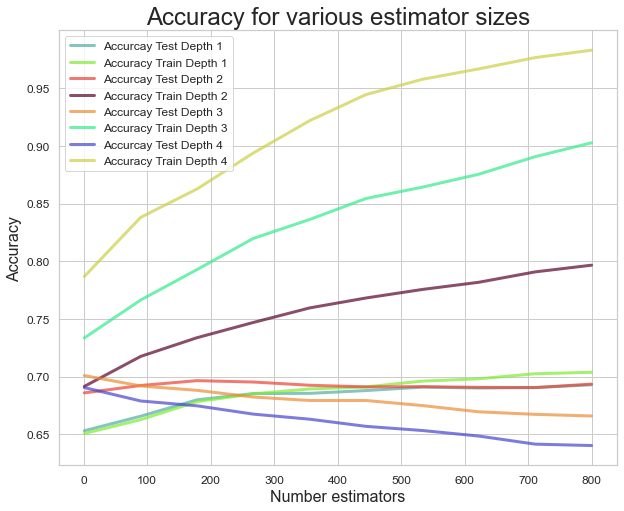

In [451]:
# your code here
n = np.linspace(1,800,10)
plt.figure(figsize=(10,8))
plt.plot(n,Ada_acc_test1,alpha=0.7,linewidth=3,color='#50AEA4', label='Accurcay Test Depth 1')
plt.plot(n,Ada_acc_train1,alpha=0.7,linewidth=3,color='#80eb34', label='Accuracy Train Depth 1')
plt.plot(n,Ada_acc_test2,alpha=0.7,linewidth=3,color='#eb4034', label='Accurcay Test Depth 2')
plt.plot(n,Ada_acc_train2,alpha=0.7,linewidth=3,color='#59032a', label='Accuracy Train Depth 2')
plt.plot(n,Ada_acc_test3,alpha=0.7,linewidth=3,color='#eb8c34', label='Accurcay Test Depth 3')
plt.plot(n,Ada_acc_train3,alpha=0.7,linewidth=3,color='#34eb8c', label='Accuracy Train Depth 3')
plt.plot(n,Ada_acc_test4,alpha=0.7,linewidth=3,color='#4644cf', label='Accurcay Test Depth 4')
plt.plot(n,Ada_acc_train4,alpha=0.7,linewidth=3,color='#cdcf44', label='Accuracy Train Depth 4')

plt.title('Accuracy for various estimator sizes',fontsize=24)
plt.xlabel('Number estimators',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

The data seems to show that a test depth of 3 and 1 estimator to be the best method. It looks like this model begins to overfit quicker as the model depth gets larger (1 and 2 depth) then immediately begins decreasing in accuracy and overfitting with the depth 3 and 4 sets. 

<div class='exercise-r'>  
 
**4.5** Based on the plot you just made, what combination of base learner depth and the number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?
 </div>

In [452]:
# your code here
display(results_df)
Ada_acc_test3[0]

,classifier,training accuracy,test accuracy
0,single tree with best depth chosen by CV,0.6036,0.6132
1,single depth-X tree,0.6812,0.6482
2,bagging 55 depth-X trees,0.9984,0.6902
3,Random Forest of 55 depth-X trees,99.9600,69.4600


0.701

The depth 3 tree with 1 estimator seems to perform the best. The accuracy of this is pretty good as it appears to be 70.04%. Not sure if you guys want me to do anything else here? This is considerably better than all of the other models I had except the random forest of 55 depth-X trees which is less than a half of a percent more accurate on the test data than our depth 3 with 1 estimator. Really unclear here if you wanted extra code, couldn't find answers on the chat to this question. 

### <div class='exercise'>Question 5 [15pts]: Understanding</div>
[▲ Return to contents](#Contents)
<div class='exercise'>
This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other material outside this homework to answer these questions.
    

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?

</div>


## Answers

<div class='exercise-r'>  
 
**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?
 
 
 </div>

Boosting and bagging are similar in that they take a series or weaker models and aggregate them into a stronger performing one. 
Both bagging and boosting take random samples with replacement from the training data.
Boosting differs in that bagging works in parallel whil;e boosting instead works in sequence, weighting the results of each randomly selected tree. Boosting takes into consideration its previous models success and decides on a weight for that model dependent on its success. Thus a really well fit model(with a good classification result) will bare more weight than a worse one when it comes time to aggregate the results. 

<div class='exercise-r'>  
 
**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?
 
 </div>

Overall the results of our AdaBoost classifier and our bagging classifier were nearly identical. This is something that will typically vary form model to model. our RandomForest bagging worked slightly better than our AdaBoost model. Its worth noting that the AdaBoost classifier took significantly more time to run. I think the performance happened in this way since there were modertately important variables that the RandomForest, due to its lack of progressive weighting, couldn't devalue as much as it maybe should have. This can be seen in my charts in 3.2/

<div class='exercise-r'>  
 
**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?
 
 </div>

From my answers to 4.4 we can see the effects of increasing the number of trees in AdaBoost. For models with depths greater than 1, we generally saw the accuracy trend down as the number of trees increased. Adding more trees can lead to overfitting in the boosting case. 

Gernerally for RandomForest/bagging, increasing the number of trees in the ensumble does not increase the risk of overfitting. The number of trees can cause things to become more correlated however and increase the variance. The same is true for both models 

<div class='exercise-r'>  
 
**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?
 
 </div>

Bagging is definitely more suited for this since it takes random samples that do not have an effect on the next random sample pulled. Boosting on the other hand is sequential. 



<div class='exercise-r'>  
 
**5.5** Which of these techniques can be extended to regression tasks? How?
 
 </div>

Boosting is more suited for regression tasks. We do this by replacing the error function with the exponential loss function. This gives us differentiable error that we can then apply gradient descent techniques to. 

### End of Notebook